##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chapter 5 - The Many Variables & The Spurious Waffles

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/statistical_rethinking/notebooks/05_the_many_variables_and_the_spurious_waffles"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/05_the_many_variables_and_the_spurious_waffles.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/05_the_many_variables_and_the_spurious_waffles.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/statistical_rethinking/notebooks/05_the_many_variables_and_the_spurious_waffles.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports and utility functions

In [2]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [3]:
#@title Install { display-mode: "form" }
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Upgrading daft ...")
    !pip install --upgrade -q daft
    print("Installing watermark, arviz, causalgraphicalmodels ...")
    !pip install -q causalgraphicalmodels
    !pip install -q arviz

In [4]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization 
import daft
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [5]:
az.style.use('seaborn-colorblind')

### Sampling helpers


In [6]:
USE_XLA = False  #@param
USE_MCMC = True  #@param

In [7]:
def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

In [8]:
NUMBER_OF_SAMPLES = 20000           #@param

MCMC_NUMBER_OF_CHAINS  = 2        #@param 
MCMC_NUMBER_OF_BURNIN  = 500      #@param
MCMC_NUMBER_OF_LEAPFROG_STEPS = 4 #@param

VI_LEARNING_RATE = 0.1            #@param
VI_NUMBER_OF_STEPS = 2000         #@param
VI_SAMPLE_SIZE = 1                #@param


@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=MCMC_NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=MCMC_NUMBER_OF_BURNIN):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
    )         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors,
    )       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior_vi(
              jdc, 
              observed_data,
              init_config,
              vi_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = dict()
    constraining_bijectors = dict()
    for p in params:
        init_state[p] = init_config[p]['state'][0]
        constraining_bijectors[p] = init_config[p]['bijector']
        
    initial_unconstrained_loc = tf.nest.map_structure(
                lambda b, x: b.inverse(x) if b is not None else x,
                constraining_bijectors, init_state)

    def target_log_prob_fn(*args, **kwargs):
      newargs = []
      for k in params:
        newargs.append(kwargs[k])

      newargs = newargs + list(observed_data)
      return jdc.log_prob(*newargs)
        
    surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
                event_shape=tf.nest.map_structure(tf.shape, init_state),
                constraining_bijectors=constraining_bijectors,
                initial_unconstrained_loc=initial_unconstrained_loc,
                initial_unconstrained_scale=1e-4)  
    
    learning_rate = vi_config.get('learning_rate', VI_LEARNING_RATE)
    num_steps     = vi_config.get('num_steps', VI_NUMBER_OF_STEPS)
    sample_size   = vi_config.get('sample_size', VI_SAMPLE_SIZE)
    
    losses = tfp.vi.fit_surrogate_posterior(
                  target_log_prob_fn,
                  surrogate_posterior=surrogate_posterior,
                  num_steps=num_steps,
                  optimizer=tf.optimizers.Adam(learning_rate),
                  sample_size=sample_size)

    results = surrogate_posterior.sample((MCMC_NUMBER_OF_CHAINS, num_samples))
        
    az_trace = _trace_to_arviz(trace=results)

    return results, az_trace


def sample_posterior_hmc(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = []
    bijectors = []
    for p in params:
        init_state.append(init_config[p]['state'])
        bijectors.append(init_config[p]['bijector'])

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  
    
    
    step_size  = mcmc_config.get('step_size', 0.1)
    num_chains = mcmc_config.get('num_chains', MCMC_NUMBER_OF_CHAINS)
    burnin     = mcmc_config.get('burnin', MCMC_NUMBER_OF_BURNIN)
    
    results, sample_stats = run_hmc_chain(
        init_state,
        bijectors,
        step_size=step_size,
        target_log_prob_fn=target_log_prob_fn,                                      
        num_samples=num_samples, 
        burnin=burnin,
    )

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

    return posterior, az_trace

def sample_posterior(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              vi_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    if USE_MCMC:
        return sample_posterior_hmc(jdc, observed_data, init_config,mcmc_config,num_samples)
    
    return sample_posterior_vi(jdc, observed_data, init_config,mcmc_config,num_samples)    


### Dataset URLs & Utils

In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"
MILK_DATASET_PATH = f"{_BASE_URL}/milk.csv"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"

In [10]:
# A utility method to convert data (columns) from pandas dataframe
# into tensors with appropriate type
def df_to_tensors(name, df, columns, default_type=tf.float32):
    """ name : Name of the dataset
        df : pandas dataframe
        colums : a list of names that have the same type or
                 a dictionary where keys are the column names and values are the tensorflow type (e.g. tf.float32)
    """
    if isinstance(columns,dict):
        column_names = columns.keys()
        fields = [tf.cast(df[k].values, dtype=v) for k,v in columns.items()]    
    else:
        column_names = columns        
        fields = [tf.cast(df[k].values, dtype=default_type) for k in column_names]    
        
    # build the cls
    tuple_cls = collections.namedtuple(name, column_names)    
    # build the obj
    return tuple_cls._make(fields)

# Introduction

## 5.1 Spurious association

We will load a data set of marriage and divorce rates to examine spurious association. Our first operation will be to standardize our rates. 

##### Code 5.1

In [11]:
d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())

Here's a linear regression model that uses median age as the predictor variable:

$D_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_AA_i$   

$\alpha \sim Normal(0,0.2)$       

$\beta_A \sim Normal(0,0.5)$          

$\sigma \sim Exponential(1)$ 

> $D_i$ is the standardized (zero centered, standard deviation one) divorce rate for State *i*, and $A_i$ is State *i*’s standardized median age at marriage. 

Since both of these rates are standardized, the intercept ($\alpha$) should be close to zero. 

A slope of ($\beta_A$)=1 would then imply that a change in one standard deviation in marriage rate is associated with change of one standard deviation in divorce. 

Below, we compute the standard deviation in median age at marriage.

##### Code 5.2

In [12]:
d.MedianAgeMarriage.std()

1.2436303013880823

> So when $\beta_A$ = 1, a change of 1.2 years in median age at marriage is associated with a full standard deviation change in the outcome variable.

Next, we'll compute the approximate posterior, in a manner similar to what we did in the previous chapter. 

##### Code 5.3

In [13]:
tdf = df_to_tensors('WaffleDivorce', d, ['A', 'D'])

def model_5_1(median_age_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_1 = model_5_1(tdf.A)

init_samples = jdc_5_1.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaA = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)


posterior_5_1, trace_5_1 = sample_posterior(
                                jdc_5_1, 
                                init_config=init_config,
                                observed_data=(tdf.D, ))

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.


Before we do posterior analysis let's check our priors

##### Code 5.4

In [14]:
# Below we are using the value of A (median age) 
A = tf.constant([-2,2], dtype=tf.float32)
jdc_5_1_prior = model_5_1(A)
prior_pred_samples = jdc_5_1_prior.sample(1000)

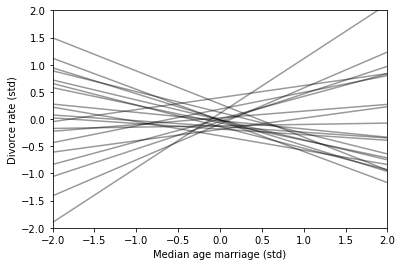

In [15]:
prior_alpha = prior_pred_samples[0]
prior_beta  = prior_pred_samples[1]
prior_sigma = prior_pred_samples[2]

ds, samples = jdc_5_1_prior.sample_distributions(value=[
    prior_alpha,
    prior_beta,
    prior_sigma,
    None
])

mu = ds[-1].distribution.loc

plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
    
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)");

>These are weakly informative priors in that they allow some implusibly strong relationships but generally bound the lines to possible ranges of the variables

We now summarize the posterior with mean and percentile interval.

##### Code 5.5



In [16]:
sample_alpha = posterior_5_1["alpha"][0]
sample_betaA = posterior_5_1["betaA"][0]
sample_sigma = posterior_5_1["sigma"][0]

A_seq = tf.linspace(start=-3., stop=3.2, num=30)
A_seq = tf.cast(A_seq, dtype=tf.float32)

# we are creating a new model for the test values
jdc_5_1_test = model_5_1(A_seq)

# we will sample it using the trace_5_1
ds, samples = jdc_5_1_test.sample_distributions(value=[
    sample_alpha,
    sample_betaA,
    sample_sigma,
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

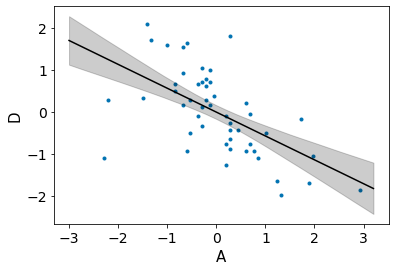

In [17]:
# plot it all
az.plot_pair(d[["A", "D"]].to_dict(orient="list"))
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);
plt.plot(A_seq, mu_mean, "k");

In the plot above, we see that there is a strong negative correlation between the age at marriage and divorce rate.




We can now model a simple regression for the marriage rate as well.

##### Code 5.6 

In [18]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('WaffleDivorce', d, ['A', 'D', 'M'])

def model_5_2(marriage_rate_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaM * marriage_rate_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_2 = model_5_2(tdf.M)

init_samples = jdc_5_2.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaM = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)


posterior_5_2, trace_5_2 = sample_posterior(
                jdc_5_2, 
                init_config=init_config,
                observed_data=(tdf.D,))

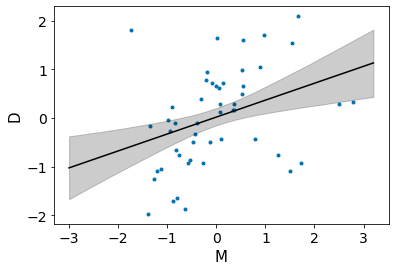

In [19]:
sample_alpha = posterior_5_2["alpha"][0]
sample_betaM = posterior_5_2["betaM"][0]
sample_sigma = posterior_5_2["sigma"][0]

M_seq = tf.linspace(start=-3., stop=3.2, num=30)
M_seq = tf.cast(M_seq, tf.float32)

# we are creating a new model for the test values
jdc_5_2_test = model_5_2(M_seq)

# we will sample it using the trace_5_1
ds, samples = jdc_5_2_test.sample_distributions(value=[
    sample_alpha, 
    sample_betaM, 
    sample_sigma, 
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

# plot it all
az.plot_pair(d[["M", "D"]].to_dict(orient="list"))
plt.fill_between(M_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);
plt.plot(M_seq, mu_mean, "k");


In the plot above we see that although the marriage rate is positively correlated with the divorce rate, the effect is not as strong as that between age and divorce rate.

> But merely comparing parameter means between different bivariate regressions is no way to decide which predictor is better. Both of these predictors could provide independent value, or they could be redundant, or one could eliminate the value of the other.

> To make sense of this, we’re going to have to think causally.

### 5.1.1. Think before you regress

We want to represent that:

a) Age directly influences the divorce rate

b) The marriage rate directly influences the divorce rate

c) Age directly influences the marriage rate

We can represent these relationships in a directed acyclic graph (DAG), as shown below, where we use python packages `causalgraphicalmodel` and `daft` to specify and draw DAGs.

##### Code 5.7

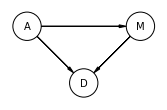

In [20]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()



##### Code 5.8

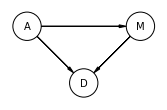

In [21]:
dag5_2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

### 5.1.2 Testable implications

>Any DAG may imply that some variables are independent of others under certain conditions. These are the model’s testable implications, its CONDITIONAL INDEPENDENCIES

Here's an interesting question to ponder: Is there indeed a direct effect of marriage rate on divorce, as in the first DAG in Code 5.7, or rather is age at marriage just driving both as in Code 5.8, creating a spurious correlation between marriage rate and divorce rate? In other words, are marriage and divorce conditionally independent if you know the age of someone?

We can list the conditonal independence assumptions of each DAG:

##### Code 5.9

In [22]:
DMA_dag1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
print ("DAG1 dependencies:")
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)
        
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
print ("DAG2 dependencies:")
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

DAG1 dependencies:
DAG2 dependencies:
('M', 'D', {'A'})


For the first DAG, there are no assumptions of conditional independence, while in the second DAG, we are implying that  `D_||_M | A`. M & D are conditionally indepenedent given A

### 5.1.4 Approximating the posterior

To fit the model to the divorce data, we just expand the linear model to include the marriage rate:

$D_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_MM_i + \beta_AA_i$   

$\alpha \sim Normal(0,0.2)$       

$\beta_M \sim Normal(0,0.5)$          

$\beta_A \sim Normal(0,0.5)$          

$\sigma \sim Exponential(1)$ 


##### Code 5.10

In [23]:
def model_5_3(median_age_data, marriage_rate_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))          
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data + betaM * marriage_rate_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_3 = model_5_3(tdf.A, tdf.M)

init_samples = jdc_5_3.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaA = dict(state = init_samples[1], bijector=tfb.Identity()),
    betaM = dict(state = init_samples[2], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[3], bijector=tfb.Exp())
)


posterior_5_3, trace_5_3 = sample_posterior(
                                jdc_5_3, 
                                init_config=init_config,
                                observed_data=(tdf.D,))

In [24]:
az.summary(trace_5_3, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],-0.00,0.10,-0.17,0.16
betaA[0],-0.61,0.16,-0.86,-0.35
betaM[0],-0.06,0.16,-0.31,0.20
sigma[0],0.83,0.09,0.69,0.96


The weight for marriage rate in `betaM` is approaching zero while the weight for age in `betaA` is more or less unchanged from the previous model. Here's the posterior distributions for the parameters in our model:


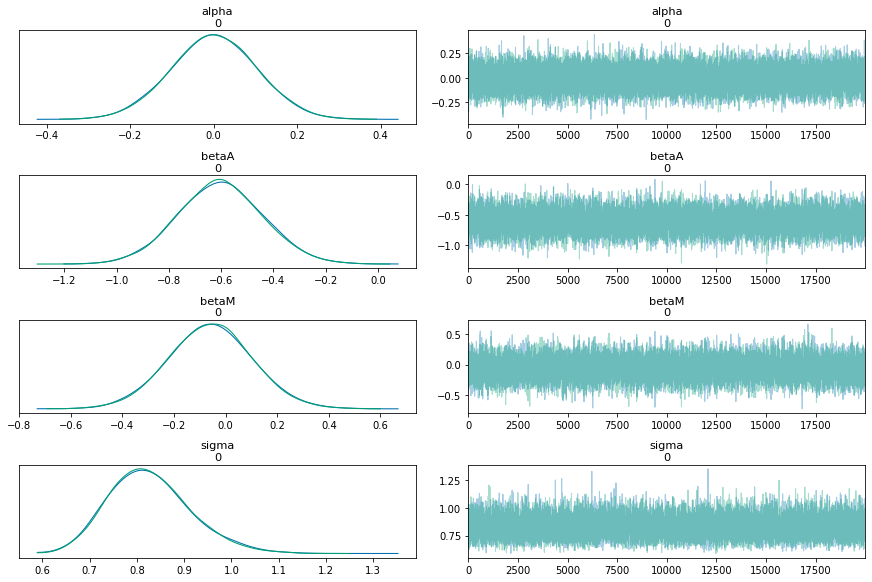

In [25]:
az.plot_trace(trace_5_3);

Here, we will use the forest plot to compare the posteriors of the three models that we have built so far:

##### Code 5.11



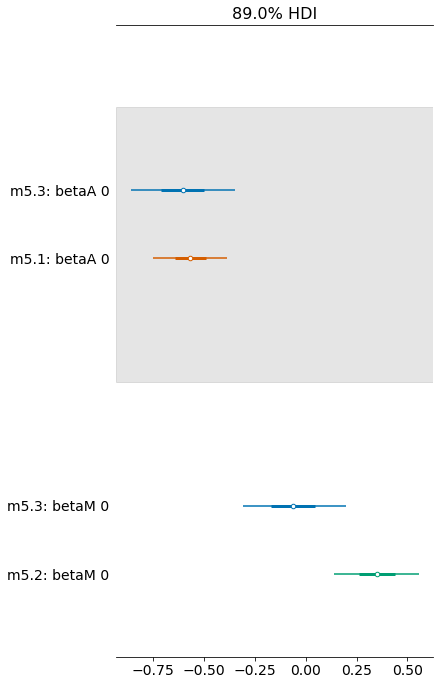

In [26]:
coeftab = {"m5.3": trace_5_3,
           "m5.2": trace_5_2,
           "m5.1": trace_5_1}

az.plot_forest(list(coeftab.values()), 
               model_names=list(coeftab.keys()),
               var_names=["betaA", "betaM"], 
               combined=True,
               hdi_prob=0.89);

m5.1 is our first model, where we used only age at marriage to predict divorce rate in each state. If we compare it to m5.3 it is more or less at the same place.

m5.2 is our second model where we used only marriage rate to predict divorce rate, omitting age at marriage. Note that in our last model with both age and marriage rate as variables, the parameter value for marriage is now close to 0, while in the second model the 89% highest density interval doesn't even include 0.  In other words, the marriage rate is associated with divorce only when age at marriage is omitted from the model. 

Based on these results, we conclude: 

> Once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that state

### Overthinking: Simulating the divorce example

We can use our causal model $M$ ← $A$ → $D$ to simulate values for each of the variables:

##### Code 5.12 

In [27]:
N = 50  # number of simulated States
age = tfd.Normal(loc=0., scale=1.).sample((N,))  # sim A
mar = tfd.Normal(loc=age, scale=1.).sample()  # sim A -> M
div = tfd.Normal(loc=age, scale=1.).sample()  # sim A -> D

### 5.1.5 Plotting multivariate posteriors

When we had only one predictor variable, a single scatterplot conveyed a lot of information, particularly when enhanced with regression lines and intervals.

However, for multivariate regression we'll need other types of plots, described below.


#### 5.1.5.1 Predictor residual plots

>A predictor variable residual is the average prediction error when we use all of the other predictor variables to model a predictor of interest.

Since we have only two predictors in our model of divorce rate, we just use one predictor to compute the predictor residuals for the other predictor. To compute the predictor residuals for marriage rate $M$, we regress marriage rate on median age at marriage $A$:

$M_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta A_i$   

$\alpha \sim Normal(0,0.2)$       

$\beta \sim Normal(0,0.5)$          

$\sigma \sim Exponential(1)$ 




##### Code 5.13

In [28]:
def model_5_4(median_age_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data
        
      M = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="M"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_4 = model_5_4(tdf.A)

init_samples = jdc_5_4.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaA = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)

posterior_5_4, trace_5_4 = sample_posterior(
                                jdc_5_4, 
                                init_config=init_config,
                                observed_data=(tdf.D,))

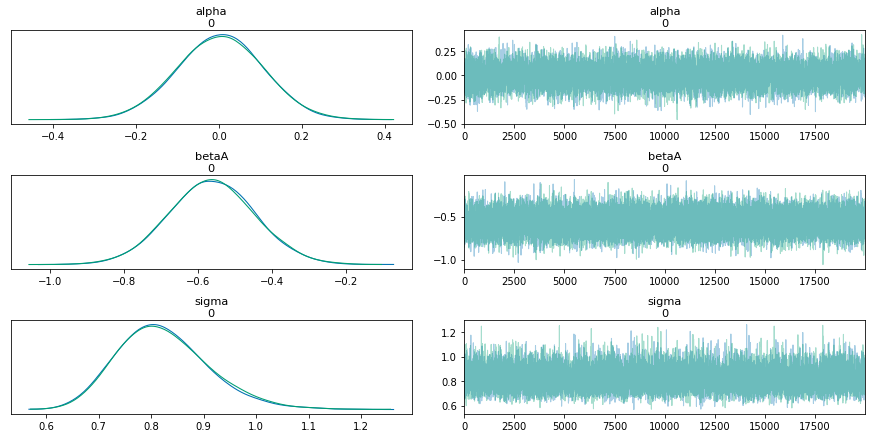

In [29]:
az.plot_trace(trace_5_4);

We compute the *residuals* by subtracting the observed marriage rate in each state from the predicted rate:

##### Code 5.14

In [30]:
sample_alpha = posterior_5_4["alpha"][0]
sample_betaA = posterior_5_4["betaA"][0]
sample_sigma = posterior_5_4["sigma"][0]

ds, samples = jdc_5_4.sample_distributions(value=[
    sample_alpha,
    sample_betaA,
    sample_sigma,
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_resid = d.M.values - mu_mean

mu_resid

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.32121938,  1.160561  , -0.06800206,  0.8574905 ,  0.0698047 ,
        0.7291903 , -0.09378165,  1.0322633 ,  1.0171134 , -0.6646397 ,
        0.45132032,  1.6423407 ,  0.2003609 , -0.1554057 , -0.24503091,
        0.06645346,  0.04292721, -0.02149898,  0.05636577, -1.5862004 ,
        0.08604944, -0.02768278, -0.79629123, -1.1576318 , -0.3313051 ,
       -0.6063713 , -0.58732486, -0.43382227, -0.5621226 , -0.65400416,
       -0.04167176,  0.19024158, -0.08704909,  1.3902502 , -0.7363469 ,
        0.21828067, -0.34587225, -0.74195623, -0.3744579 , -0.3750064 ,
       -0.21141672, -0.57723904, -0.02430266,  1.2462848 , -0.5957351 ,
        0.25692084,  0.2670082 ,  0.0692575 , -0.65735596,  1.9443163 ],
      dtype=float32)>

> When the residual is positive, that means that the observed rate was in excess of what the model expects, given the median age at marriage in that state. When the residual is negative, that means that the observed rate was below what the model expects.... States with positive residuals have high marriage rates for their median age of marriage, while states with negative residuals have low rates for their median age of marriage.
 

#### 5.1.5.2 Posterior prediction plots

We can compare the model's predictions to the observed data to investigate:

*   Did the model correctly approximate the posterior distribution ?
*   How does the model fail ?

We'll start by simulating new samples of our divorce rate using the posterior samples of our parameters from the previous run our model.

##### Code 5.15

In [31]:
sample_alpha = posterior_5_3["alpha"][0]
sample_betaA = posterior_5_3["betaA"][0]
sample_betaM = posterior_5_3["betaM"][0]
sample_sigma = posterior_5_3["sigma"][0]

ds, samples = jdc_5_3.sample_distributions(value=[
    sample_alpha,
    sample_betaA,
    sample_betaM,
    sample_sigma, 
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0).numpy()

# get the simulated D
D_sim = samples[-1]
D_PI = tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0)    

D_sim.shape

TensorShape([20000, 50])

Next, we plot predictions against observed:

##### Code 5.16

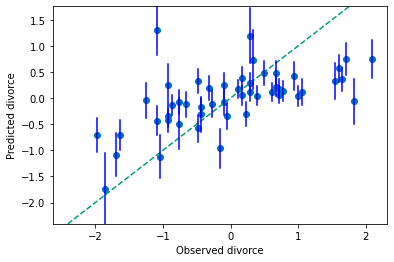

In [32]:
ax = plt.subplot(ylim=(float(mu_PI.min()), float(mu_PI.max())),
                 xlabel="Observed divorce", ylabel="Predicted divorce")
plt.plot(d.D, mu_mean, "o")
x = np.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

The diagonal line shows where posterior predictions exactly match the sample, while the line segments show the compatibility interval of each prediction.

We can label the posterior prediction for the states where predicted differs from observed most:

##### Code 5.17

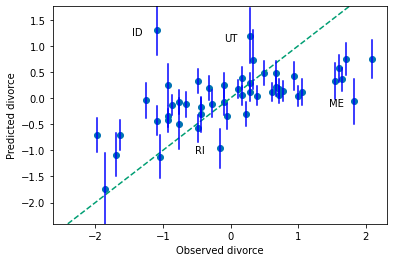

In [33]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5),
                    textcoords="offset pixels")
fig

We see that the model under predicts for states with high divorce rates, while it over predicts for states with low divorce rates.

> What is unusual about Idaho and Utah? Both of these States have large proportions of members of the Church of Jesus Christ of Latter-day Saints. Members of this church have low rates of divorce, wherever they live.


### Overthinking: Simulating spurious association

>One way that spurious associations between a predictor and outcome can arise is when a truly causal predictor, call it $x_{real}$, influences both the outcome, y, and a spurious predictor, $x_{spur}$.

We'll first run a simple simulation to generate some data:

##### Code 5.18 

In [34]:
N = 100  # number of cases

# x_real as Gaussian with mean 0 and stddev 1
x_real = tfd.Normal(loc=0., scale=1.).sample((N,))

# x_spur as Gaussian with mean=x_real
x_spur = tfd.Normal(loc=x_real, scale=1.).sample()

# y as Gaussian with mean=x_real
y = tfd.Normal(loc=x_real, scale=1.).sample()

# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

In [35]:
d

,y,x_real,x_spur
0,0.137413,0.937597,0.573253
1,-1.690685,-1.271168,-0.711359
2,-0.022631,0.702230,0.017888
3,-0.720411,0.794819,-0.231515
4,0.633710,0.148588,0.873148
...,...,...,...
95,0.157278,-0.295777,0.370917
96,-0.990142,-1.750185,-2.497891
97,-0.180196,0.144420,-0.260867
98,-1.062965,-1.510616,-1.568656


> Because `x_real` influences both `y` and `x_spur`, you can think of `x_spur` as another outcome of `x_real`, but one which we mistake as a potential predictor of y. As a result, both $x_{real}$ and $x_{spur}$ are correlated with $y$.

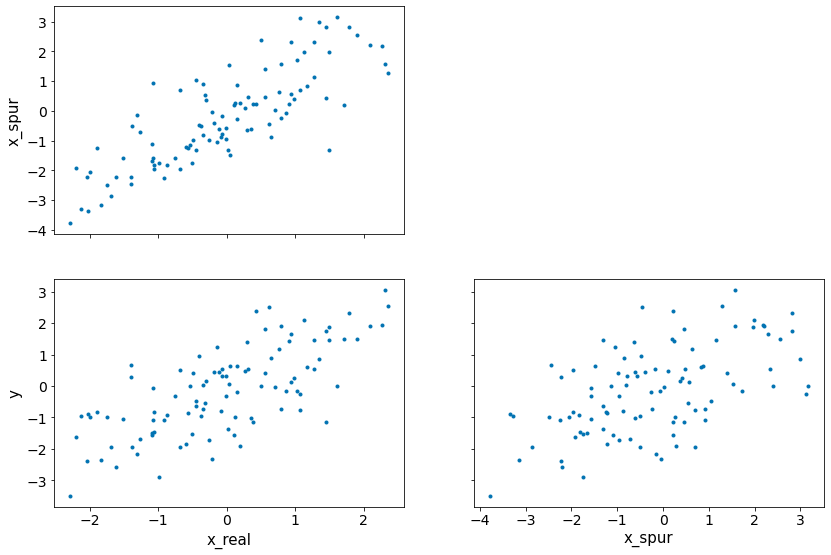

In [36]:
# use a plot to show the correlations for all pairs of variables
# Not shown in the book
az.plot_pair({"x_real":x_real, "x_spur":x_spur, "y":y});

### 5.1.5.3 Counterfactual plots

You can produce counterfactual plots for any values of predictor variables, even unlikely combinations, to show the causal implications of your model. The simplest use of counterfactual plot is to see how the prediction changes as we change **only one** predictor at a time.

To our model m5.3, we need to add a regression of the effect of age at marriage $A$ on marriage rate $M$, to model the influence of A→M.


##### Code 5.19




In [37]:
# Reloading the dataset

d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('WaffleDivorce', d, ['A', 'D', 'M'])

In [38]:
def model_5_3_A(median_age_data, marriage_rate_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))          
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data + betaM * marriage_rate_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    

def model_5_X_M(median_age_data): # for effect of age at marriage on rate of marriage, A→M
    def _generator():
      alphaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alphaM"), sample_shape=1))
      betaAM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaAM"), sample_shape=1))      
      sigmaM = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigmaM"), sample_shape=1))
    
      mu_M =  alphaM + betaAM * median_age_data 
        
      M = yield tfd.Independent(tfd.Normal(loc=mu_M, scale=sigmaM, name="M"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    

## First model
jdc_5_3_A = model_5_3_A(tdf.A, tdf.M)

init_samples = jdc_5_3_A.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaA = dict(state = init_samples[1], bijector=tfb.Identity()),
    betaM = dict(state = init_samples[2], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[3], bijector=tfb.Exp())
)

posterior_5_3_A, trace_5_3_A = sample_posterior(
                        jdc_5_3_A, 
                        init_config=init_config,
                        observed_data=(tdf.D,))

## Second model
jdc_5_X_M = model_5_X_M(tdf.A)


init_samples = jdc_5_X_M.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaA = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)

posterior_5_X_M, trace_5_X_M = sample_posterior(
                        jdc_5_X_M, 
                        init_config=init_config,
                        observed_data=(tdf.M,))


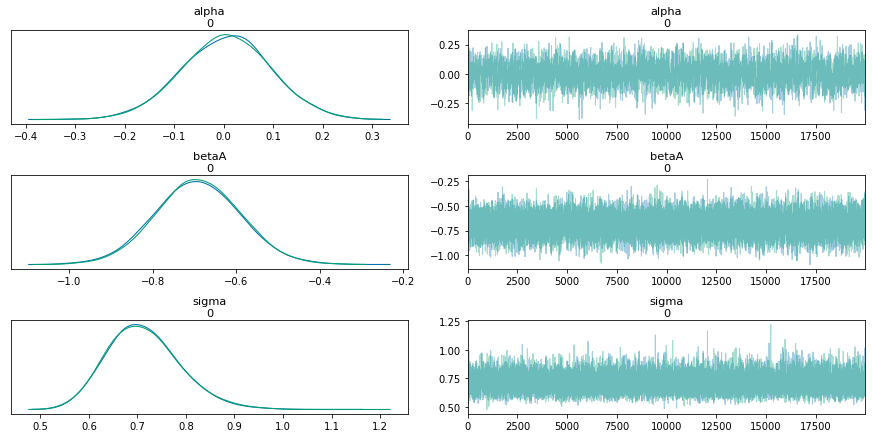

In [39]:
az.plot_trace(trace_5_X_M);

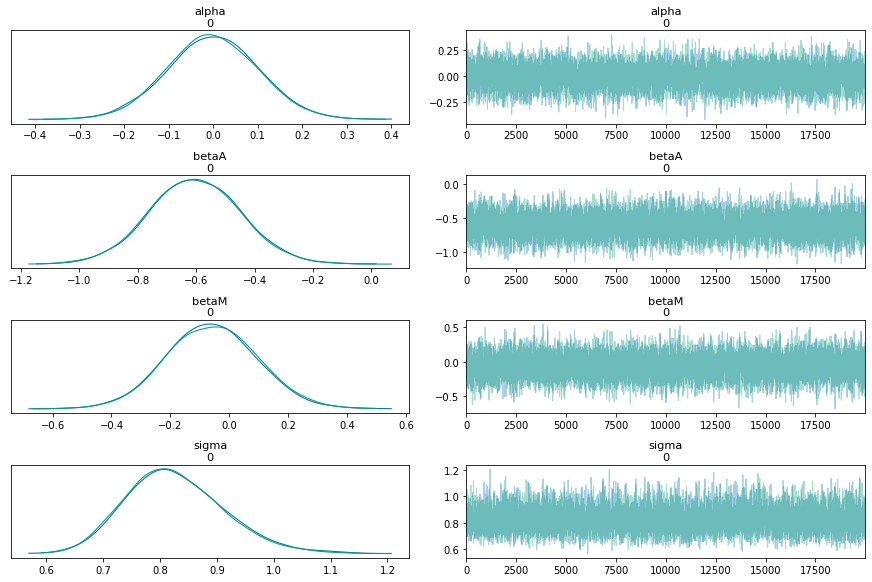

In [40]:
az.plot_trace(trace_5_3_A);

From the plots above of `betaA` for `model_5_X_M`, we see the posterior estimates for `betaA` centered around -0.7, showing a clear negative association between age at marriage and the marriage rate.

Let's see what would happen if we manipulate $A$, with a list of 30 interventions ranging from two standard deviations below to two above the mean.

##### Code 5.20

In [41]:
A_seq = tf.linspace(-2.0, 2.0, num=30)
A_seq = tf.cast(A_seq, dtype=tf.float32)

Recognizing the causality in our DAG, we'll first simulate the influence of $A$ on $M$: 

##### Code 5.21

In [42]:
sample5X_alpha = posterior_5_X_M["alpha"][0]
sample5X_betaA = posterior_5_X_M["betaA"][0]
sample5X_sigma = posterior_5_X_M["sigma"][0]


jdc_5_X_M_test = model_5_X_M(A_seq)

samples = jdc_5_X_M_test.sample(value=[
    sample5X_alpha, 
    sample5X_betaA, 
    sample5X_sigma, 
    None
])

M_sim = samples[-1]

M_sim.shape

TensorShape([20000, 30])

Then, we can simulate the influence of both $A$ and $M$ on $D$:

In [43]:
sample53A_alpha  = posterior_5_3_A["alpha"][0]
sample53A_betaA  = posterior_5_3_A["betaA"][0]
sample53A_betaM  = posterior_5_3_A["betaM"][0]
sample53A_sigma  = posterior_5_3_A["sigma"][0]

jdc_5_3_A_test = model_5_3_A(A_seq, M_sim)

_, _, _, _, D_sim = jdc_5_3_A_test.sample(value=[
    sample53A_alpha,
    sample53A_betaA,
    sample53A_betaM,
    sample53A_sigma,
    None
])

D_sim.shape

TensorShape([20000, 30])

Finally, we plot the predictions:

##### Code 5.22

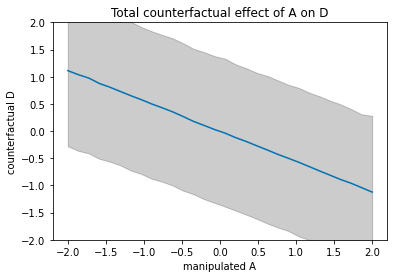

In [44]:
# display counterfactual predictions
plt.plot(A_seq, tf.reduce_mean(D_sim, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(A_seq, *tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of A on D");

The plot above shows the total causal effect of manipulating $A$ on $D$. The model allows some of the total causal effect of $A$ to act through $M$, although the posterior distribution finds little support for an effect of $M$ on $D$. This plot nevertheless contains the effects of both paths, $A$ → $D$ and $A$ → $M$ → $D$.

We’ll simulate a counterfactual for an average state, with $A$ = 0, and see what changing $M$ does.

##### Code 5.23  

In [45]:
M_seq = tf.linspace(-2.0, 2.0, num=30)
M_seq = tf.cast(M_seq, dtype=tf.float32)

def compute_D_from_posterior_using_M(m):
    mu = sample53A_alpha + sample53A_betaM * m
    return tfd.Normal(loc=mu, scale=sample53A_sigma).sample()        

D_sim = tf.transpose(tf.squeeze(tf.vectorized_map(compute_D_from_posterior_using_M, M_seq)))
D_sim.shape

TensorShape([20000, 30])

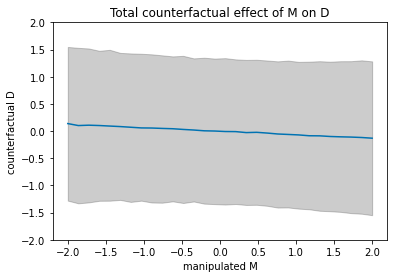

In [46]:
# display counterfactual predictions
plt.plot(M_seq, tf.reduce_mean(D_sim, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated M", ylabel="counterfactual D")
plt.fill_between(M_seq, *tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of M on D");

> The counterfactual effect of manipulating marriage rate $M$ on divorce rate $D$. Since $M$ → $D$ was estimated to be very small, there is almost no trend here. By manipulating $M$, we break the influence of $A$ on $M$, and this removes the association between $M$ and $D$

### Overthinking: Simulating counterfactuals

##### Code 5.24, 5.25, 5.26, & 5.27

(Here, the author explains how to simulate counterfacturals manually, versus using the R `sim` function. In the TFP code examples above, we are already doing the simulations manually.)

## 5.2 Masked relationship

> The divorce rate example demonstrates that multiple predictor variables are useful for knocking out spurious association. A second reason to use more than one predictor variable is to measure the direct influences of multiple factors on an outcome, when none of those influences is apparent from bivariate relationships.

##### Code 5.28


We are going to use a new dataset called Milk.

> The question here is to what extent energy content of milk, measured here by kilocalories, is related to the percent of the brain mass that is neocortex.



In [47]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


In [48]:
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


* kcal.per.g - Kilocalories of energy per gram of milk
* mass - Average female body mass, in KG
* neocortex.perc - Percent of total brain mass that is neocortex mass

Although not mentioned in the question that was asked above, we are considering the female body mass as well--to investigate the masking that hides the relationships among the variables.

First, we will standardize the variables.

##### Code 5.29

In [49]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('Milk', d, ['K', 'N', 'M'])

Our first model is simple bivariate model between kcal and percent of neocortex mass:

$K_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_NN_i$

> where $K$ is standardized kilocalories and $N$ is standardized neocortex percent.

##### Code 5.30

In [50]:
# N => Standardized Neocortex percent

def model_5_5_draft(neocortex_percent_std):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="alpha"), sample_shape=1))
      betaN = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="betaN"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaN * neocortex_percent_std
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_5_draft = model_5_5_draft(tdf.N)

samples = jdc_5_5_draft.sample()

samples

StructTuple(var0=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.43320835], dtype=float32)>, var1=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.2043248], dtype=float32)>, var2=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.427879], dtype=float32)>, var3=<tf.Tensor: shape=(29,), dtype=float32, numpy=
array([ 2.8166475 ,         nan,         nan,         nan,         nan,
        0.30965173,  0.6189947 , -0.3877126 ,         nan, -0.57754993,
        1.5499852 ,  1.9076581 ,  1.2946354 ,         nan,         nan,
       -1.1312454 ,         nan, -0.5448464 ,         nan, -2.6912649 ,
               nan, -0.56030357,         nan, -1.6218092 , -1.6317221 ,
               nan,  0.09582442, -1.6722327 , -2.942134  ], dtype=float32)>)

Although TFP does not throw
an exception for the NANs you see in the samples,  we're going to want to avoid these.

The problem is that we have lot of data missing in the neorcortex.perc column:

##### Code 5.31

In [51]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

We will follow the method of *complete case analysis* by dropping all the cases with missing values.

##### Code 5.32

In [52]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

# we now have only 17 rows
dcc.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,1.700000e+01,17.000000
mean,0.657647,36.063529,16.255294,47.681176,16.637647,67.575882,0.098654,-2.821273e-15,0.033852
std,0.172899,14.705419,5.598480,13.585261,23.582322,5.968612,1.071235,1.000000e+00,1.138400
min,0.460000,3.930000,7.370000,27.090000,0.120000,55.160000,-1.125913,-2.080196e+00,-2.097830
25%,0.490000,27.180000,11.680000,37.800000,1.550000,64.540000,-0.940041,-5.086413e-01,-0.591039
50%,0.620000,37.780000,15.800000,46.880000,5.250000,68.850000,-0.134597,2.134697e-01,0.127441
75%,0.800000,50.490000,20.850000,55.200000,33.110000,71.260000,0.980633,6.172487e-01,1.212020
max,0.970000,55.510000,25.300000,70.770000,79.430000,76.300000,2.033906,1.461666e+00,1.727359


In [53]:
tdcc = df_to_tensors('Milk', dcc, ['K', 'N', 'M'])

We'll rebuild the model using only the 17 rows that have no missing values.
##### Code 5.33

In [54]:
jdc_5_5_draft = model_5_5_draft(tdcc.N)

samples = jdc_5_5_draft.sample()

samples

StructTuple(var0=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6965279], dtype=float32)>, var1=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5525214], dtype=float32)>, var2=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.27956265], dtype=float32)>, var3=<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([-0.4095549 ,  0.17735074,  0.36985198,  0.7929921 ,  0.77139246,
       -0.22208026,  0.22708705, -0.32934558,  0.56082404,  0.786573  ,
        1.0892625 ,  0.5874387 ,  1.1772462 ,  1.3940688 ,  1.5600021 ,
        1.475326  ,  1.0531576 ], dtype=float32)>)

Note the absence of NaN in the samples.

We'll investigate if we have proper priors by plotting 50 regression lines of priors.

##### Code 5.34

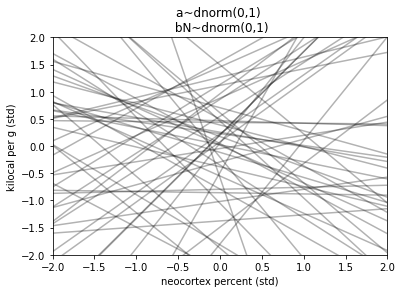

In [55]:
# We get priors from the previous model (that had used dcc as the inpu)
sample_alpha, sample_betaN, sample_sigma, sample_K = jdc_5_5_draft.sample(500)

xseq = tf.constant([-2.0,2.0], dtype=tf.float32)

# We build the new model object that take xseq as input but uses
# the prior samples from previous model
ds, samples = model_5_5_draft(xseq).sample_distributions(value=[
    sample_alpha, 
    sample_betaN, 
    sample_sigma, 
    None
])

fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, samples[-1][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");


In the plot above, we show a range of two standard deviations for both kilocalories per gram and neocortex percent.  We should have a prior for $\alpha$ so that the $\alpha$ samples are closer to zero. We also want to restrict our $\beta$ samples so that the slope doesn't show such a strong relationship between the two variables.

##### Code 5.35

In [56]:
def model_5_5(neocortex_percent_std):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaN = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaN"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaN * neocortex_percent_std
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_5 = model_5_5(tdcc.N)

init_samples = jdc_5_5.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaN = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)


posterior_5_5, trace_5_5 = sample_posterior(
                                jdc_5_5, 
                                num_samples=1000,
                                init_config=init_config,
                                observed_data=(tdcc.K,))

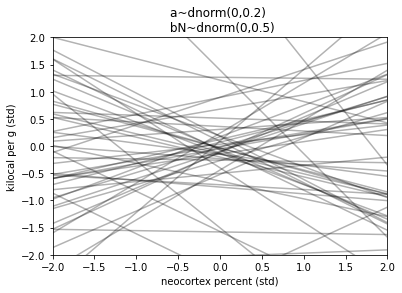

In [57]:
# There is not code section for below code
# but the author suggests to plot the priors
# of this model as well
sample_alpha, sample_betaN, sample_sigma, _ = jdc_5_5.sample(1000)

xseq = tf.constant([-2.0,2.0], dtype=tf.float32)

# We build the new model object that take xseq as input but uses
# the prior samples from previous model
ds, samples = model_5_5(xseq).sample_distributions(value=[
    sample_alpha, 
    sample_betaN, 
    sample_sigma, 
    None
])

fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, samples[-1][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,0.2) \n bN~dnorm(0,0.5)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

These priors are closer to the potential space of observations.

Now let's look at the posterior:

##### Code 5.36

In [58]:
az.summary(trace_5_5, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],0.07,0.15,-0.21,0.28
betaN[0],0.13,0.25,-0.32,0.51
sigma[0],1.13,0.21,0.80,1.45


The above summary shows that this is neither a strong nor very precise association. The standard deviation is almost twice the posterior mean


Let's plot the predicted mean and 89% compatibility interval:

##### Code 5.37

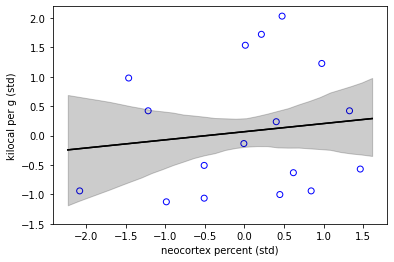

In [59]:
xseq = tf.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha =  posterior_5_5["alpha"][0]
sample_betaN =  posterior_5_5["betaN"][0]
sample_sigma =  posterior_5_5["sigma"][0] 

jdc_5_5_test = model_5_5(xseq)

ds, samples = jdc_5_5_test.sample_distributions(value=[
    sample_alpha, 
    sample_betaN, 
    sample_sigma, 
    None
])

mu_pred = ds[-1].distribution.loc

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

fig, ax = plt.subplots()
plt.plot(xseq, mu_mean, c="black")
plt.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

We see a weakly positive relationship, with precision boundaries that permit even a negative relationship.

We now consider a different predictor variable, adult female body mass. In particular, as is often done with modeling biological organisms, we'll use the log of body mass to capture influence of the magnitude of the variable.

##### Code 5.38

In [60]:
def model_5_6(female_body_mass):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaM * female_body_mass
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_6 = model_5_6(tdcc.M)

init_samples = jdc_5_6.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaM = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)


posterior_5_6, trace_5_6 = sample_posterior(
                            jdc_5_6, 
                            init_config=init_config,
                            observed_data=(tdcc.K,))

az.summary(trace_5_6, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],0.04,0.16,-0.22,0.28
betaM[0],-0.27,0.21,-0.60,0.06
sigma[0],1.06,0.19,0.76,1.34


Log-mass is negatively correlated with kilocalories. The influence is stronger than that of neocortex percent, but it is in the opposite direction. In the plot below, we see a fair amount of uncertainty, supporting weak to strongly negative relationships.

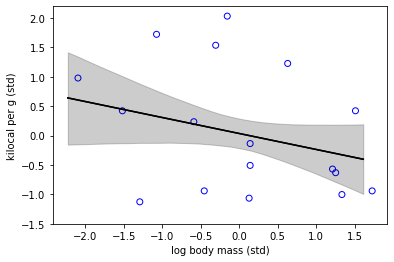

In [61]:
# note - code for plotting is not listed in the book but here we are plotting
# to show the difference from previous bivariate model

xseq = tf.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha =  posterior_5_6["alpha"][0]
sample_betaM =  posterior_5_6["betaM"][0]
sample_sigma =  posterior_5_6["sigma"][0] 

jdc_5_6_test = model_5_6(xseq)

ds, samples = jdc_5_6_test.sample_distributions(value=[
    sample_alpha, 
    sample_betaM, 
    sample_sigma, 
    None
])

mu_pred = ds[-1].distribution.loc

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

fig, ax = plt.subplots()
plt.plot(xseq, mu_mean, c="black")
plt.scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("kilocal per g (std)");

Now let's see what happens when we add both the predictor variables to the model.

$K_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_NN_i + \beta_MM_i$

$\alpha \sim Normal(0,0.02)$

$\beta_N \sim Normal(0,0.5)$

$\beta_M \sim Normal(0,0.5)$

$\sigma \sim Exponential(1)$

##### Code 5.39

In [62]:
def model_5_7(neocortex_percent_std, female_body_mass):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaN = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaN"), sample_shape=1))      
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaN * neocortex_percent_std + betaM * female_body_mass
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_7 = model_5_7(tdcc.N, tdcc.M)

init_samples = jdc_5_7.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    betaN = dict(state = init_samples[1], bijector=tfb.Identity()),
    betaM = dict(state = init_samples[2], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[3], bijector=tfb.Exp())
)

posterior_5_7, trace_5_7 = sample_posterior(jdc_5_7, 
                              init_config=init_config,
                              observed_data=(tdcc.K,))

az.summary(trace_5_7, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],0.06,0.14,-0.16,0.30
betaN[0],0.60,0.28,0.17,1.04
betaM[0],-0.64,0.25,-1.04,-0.26
sigma[0],0.87,0.18,0.59,1.13


By including both predictor variables in the regression, we increase the posterior association with the outcome for each variable. Note how they have both moved away from zero with the multivariate model:

##### Code 5.40

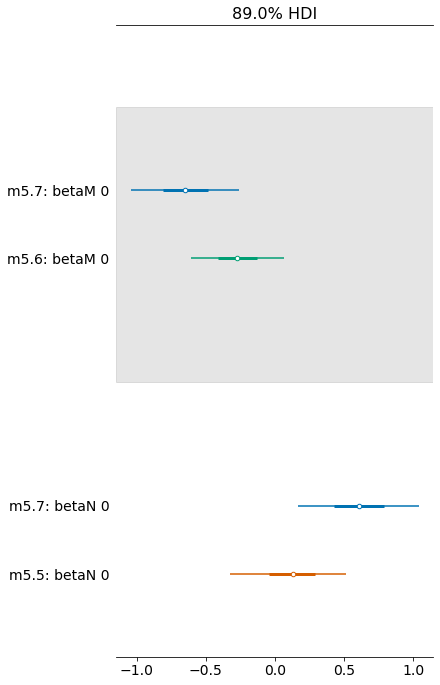

In [63]:
coeftab = {"m5.7": trace_5_7,
           "m5.6": trace_5_6,
           "m5.5": trace_5_5           
           }

az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["betaM", "betaN"],
    hdi_prob=0.89,
    combined=True,
);

> What happened here? Why did adding neocortex and body mass to the same model lead to larger estimated effects of both? This is a context in which there are two variables correlated with the outcome, but one is positively correlated with it and the other is negatively correlated with it. In addition, both of the explanatory variables are positively correlated with one another.... The result of this pattern is that the variables tend to cancel one another out.

##### Code 5.41

Counterfactual plot when setting N to zero and using M as the predictor variable 

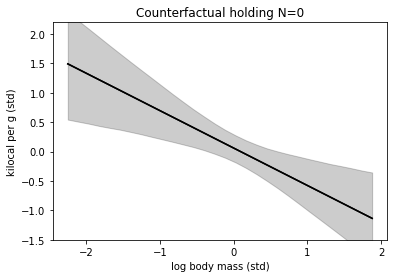

In [64]:
xseq = tf.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha =  posterior_5_7["alpha"][0]
sample_betaN =  posterior_5_7["betaN"][0]
sample_betaM =  posterior_5_7["betaM"][0]
sample_sigma =  posterior_5_7["sigma"][0] 

mu_pred = tf.transpose(tf.squeeze(tf.vectorized_map(lambda x : sample_alpha + sample_betaM * x, xseq)))

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

fig, ax = plt.subplots()
plt.plot(xseq, mu_mean, c="black")
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("kilocal per g (std)");

Counterfactual plot when setting M to zero and use N as the predictor variable.

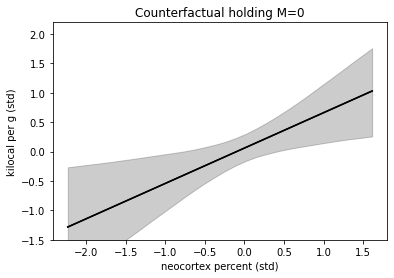

In [65]:
# Note there is corresponding code snippet but author recommends to do this
# exercise

xseq = tf.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha =  posterior_5_7["alpha"][0]
sample_betaN =  posterior_5_7["betaN"][0]
sample_betaM =  posterior_5_7["betaM"][0]
sample_sigma =  posterior_5_7["sigma"][0] 

mu_pred = tf.transpose(tf.squeeze(tf.vectorized_map(lambda x : sample_alpha + sample_betaN * x, xseq)))

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

fig, ax = plt.subplots()
plt.plot(xseq, mu_mean, c="black")
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding M=0")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

### Overthinking: Simulating a masking relatioship

It may help to simulate data in which two meaningful predictors act to mask one another.

##### Code 5.42

In [66]:
# M -> K <- N
# M -> N
n = 100
M = tfd.Normal(loc=0., scale=1.).sample((n,))
N = tfd.Normal(loc=M, scale=1.).sample()
K = tfd.Normal(loc=N - M, scale=1.).sample()

d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

d_sim

,K,N,M
0,2.363461,1.030800,0.036394
1,-0.956242,1.339037,1.356252
2,-0.790853,-2.201650,-0.687654
3,2.620039,1.914477,0.603462
4,-0.529397,0.506775,1.400875
...,...,...,...
95,0.410846,0.803220,0.695643
96,1.287338,3.010124,1.742763
97,-0.956158,-1.012569,-0.527848
98,0.741312,-0.518625,-1.221583


##### Code 5.43

In [67]:
# M -> K <- N
# N -> M
n = 100
N = tfd.Normal(loc=0., scale=1.).sample((n,))
M = tfd.Normal(loc=N, scale=1.).sample()
K = tfd.Normal(loc=N - M, scale=1.).sample()

d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = tfd.Normal(loc=0., scale=1.).sample((n,))
M = tfd.Normal(loc=M, scale=1.).sample()
K = tfd.Normal(loc=N - M, scale=1.).sample()

d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

##### Code 5.44 

The book uses `dagitty` an R package that can draw the DAG as well generate the equivalentDAGs given a DAG as input

At this point I do not have the corresponding function in python so I am manually specifying the equivalent DAGs (after seeing the result in RStudio as the book does not display the equivalentDAGs either)

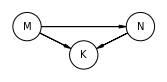

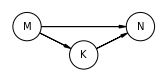

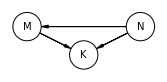

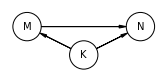

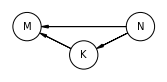

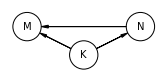

In [68]:
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
node_names = ["M", "K", "N"]

equivalent_dags = [
    [("M", "K"), ("N", "K"), ("M", "N")],
    [("M", "K"), ("K", "N"), ("M", "N")],
    [("M", "K"), ("N", "K"), ("N", "M")],
    [("K", "M"), ("K", "N"), ("M", "N")],
    [("K", "M"), ("N", "K"), ("N", "M")],
    [("K", "M"), ("K", "N"), ("N", "M")]
]

for e in equivalent_dags:
    dag = CausalGraphicalModel(nodes=node_names, edges=e)    
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
        
    pgm.render()
    plt.gca().invert_yaxis()

## 5.3 Categorical variables

This section discusses Categorical Variables i.e. Discrete & Unordered variables.

Interpreting estimates for categorical variables can be harder than for regular continuous variables.

### 5.3.1 Binary categories


Sex is a categorical variable with two values - male & female. In previous chapters, when using Kalahari data to predict the height the variable sex was ignored. It is obvious that males and females will have different average heights.

Loading Howell dataset

##### Code 5.45

In [69]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=";")
d.info();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [70]:
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


The `male` column show above is also called a dummy variable. It is example of **INDICATOR VARIABLE**

The indicator variable is used inside the linear model and its effect is to turn a *parameter on* for those cases in the category

Considering following model

$h_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_mm_i$   

$\alpha \sim Normal(178,20)$       

$\beta_m \sim Normal(0,10)$          

$\sigma \sim Exponential(1)$ 


*m* here is a categorical value and is 1 when we are dealing with males. This means that $\alpha$ is used
to predict both female and male heights.

But if we have a male then the height gets an extra $\beta_m$. This also means that $\alpha$ does not represent the average of all samples but rather the average of female height.


##### Code 5.46




In [71]:
mu_female = tfd.Normal(loc=178., scale=20.).sample((int(1e4),))

diff = tfd.Normal(loc=0., scale=10.).sample((int(1e4),))

mu_male = tfd.Normal(loc=178.0, scale=20.).sample((int(1e4),)) + diff

sample_dict = {
    'mu_female' : mu_female.numpy(),
    'mu_male' : mu_male.numpy()
}

az.summary(az.from_dict(sample_dict), round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu_female,178.15,19.92,147.04,210.18
mu_male,178.16,22.52,144.00,215.64


The prior for male is wider (see std column). This is because it uses both the parameters.

This makes assigning sensible priors harder. As shown above, one of the category would have more uncertainity in the prediction as two priors are involved.



We should not be more unsure about male height than female height, a priori. Is there another way ?

Another approach is to use **INDEX VARIABLE**.

With index variables we can assign integers to different categories

##### Code 5.47


In [72]:
d["sex"] = np.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int64

0 => Female and 1 => Male

If we imagine an array that holds our parameters, the above assigned labels can act as indices. 

Note - In the book since R is used the indices start from 1 and not 0

##### Code 5.48

Notices that `alpha` has a `sample_shape` of 2 i.e it now can hold two alphas - one for female and one for male

In [73]:
tdf = df_to_tensors('Howell1', d, {
    'height' : tf.float32,     
    'sex'    : tf.int32
})


def model_5_8(sex):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20., name="alpha"), sample_shape=(2,)))                
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50., name="sigma"), sample_shape=1))

      # took long time to figure this out
      mu = tf.transpose(tf.gather(tf.transpose(alpha), sex))      
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="height"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_8 = model_5_8(tdf.sex)

init_samples = jdc_5_8.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[1], bijector=tfb.Softplus())
)


posterior_5_8, trace_5_8 = sample_posterior(
                                jdc_5_8,
                                init_config=init_config,
                                observed_data=(tdf.height,))

In [74]:
az.summary(trace_5_8, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],134.91,1.68,132.21,137.56
alpha[1],142.58,1.39,140.31,144.73
sigma[0],27.41,0.84,26.06,28.73


What is the expected difference between females and males ?

We can use the samples from the posterior to compute this.

##### Code 5.49



In [75]:
female_alpha = posterior_5_8["alpha"][:,:,0]
male_alpha = posterior_5_8["alpha"][:,:,1]

posterior_5_8.update({    
    "diff_fm" : female_alpha.numpy() - male_alpha.numpy()
})

az.summary(az.from_dict(posterior_5_8), round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],134.91,1.68,132.21,137.56
alpha[1],142.58,1.39,140.31,144.73
sigma[0],27.41,0.84,26.06,28.73
diff_fm,-7.67,2.20,-11.28,-4.20


Note that the above computation (i.e. diff) appeared in the arviz summary. This kind of calculation is called a **CONTRAST**. 

### 5.3.2 Many categories


When there are more than two categories the indicator variable approach will not be very helpful. The INDEX VARIABLE approach is more generic and hence recommended.


We explore the mile dataset again. We are now interested in `clade` variable which encodes the broad taxonomic membership of each species

##### Code 5.50

In [76]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

There are 4 categories here and we would want an index values for each of them

##### Code 5.51

In [77]:
d["clade_id"] = d.clade.astype("category").cat.codes

d["clade_id"]

0     3
1     3
2     3
3     3
4     3
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    2
15    2
16    2
17    2
18    2
19    2
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
Name: clade_id, dtype: int8

In [78]:
d.clade

0        Strepsirrhine
1        Strepsirrhine
2        Strepsirrhine
3        Strepsirrhine
4        Strepsirrhine
5     New World Monkey
6     New World Monkey
7     New World Monkey
8     New World Monkey
9     New World Monkey
10    New World Monkey
11    New World Monkey
12    New World Monkey
13    New World Monkey
14    Old World Monkey
15    Old World Monkey
16    Old World Monkey
17    Old World Monkey
18    Old World Monkey
19    Old World Monkey
20                 Ape
21                 Ape
22                 Ape
23                 Ape
24                 Ape
25                 Ape
26                 Ape
27                 Ape
28                 Ape
Name: clade, dtype: object

Based on above it seems that pandas is first sorting the categories by name and then assigning the number. So,

* Ape = 0
* New World Monkey = 1
* Old World Monkey = 2
* Strepsirrhine    = 3


We will now model again using the index variables

##### Code 5.52

In [79]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('Milk', d, {
    'K' : tf.float32,     
    'clade_id' : tf.int64
})

CLADE_ID_LEN = len(set(d.clade_id.values))

def model_5_9(clade_id):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=.5, name="alpha"), sample_shape=(CLADE_ID_LEN,)))                
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))        

      mu = tf.transpose(tf.gather(tf.transpose(alpha), tf.cast(clade_id, dtype=tf.int64)))      
    
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_9 = model_5_9(tdf.clade_id)

init_samples = jdc_5_9.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[1], bijector=tfb.Exp())
)


posterior_5_9, trace_5_9 = sample_posterior(
                                jdc_5_9,
                                init_config=init_config,
                                observed_data=(tdf.K,))

az.summary(trace_5_9, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],-0.46,0.24,-0.85,-0.10
alpha[1],0.35,0.24,-0.03,0.72
alpha[2],0.64,0.27,0.21,1.07
alpha[3],-0.55,0.29,-1.00,-0.08
sigma[0],0.80,0.12,0.62,0.98


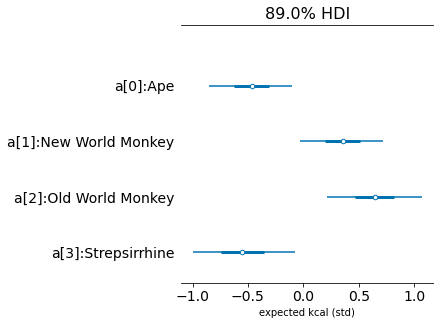

In [80]:
labels = ["a[" + str(i) + "]:" + s
          for i, s in enumerate(sorted(d.clade.unique()))]

az.plot_forest({"a" : trace_5_9.posterior["alpha"]}, hdi_prob=0.89, combined=True)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)");

The pattern is for many other types of similar problems.

Hee the primates are being assigned to another madeup category called 'house'

##### Code 5.53

In [81]:
np.random.seed(63)
d["house"] = np.random.choice(np.repeat(np.arange(4), 8), d.shape[0], False)

In [82]:
d.house

0     2
1     3
2     1
3     3
4     0
5     0
6     0
7     2
8     0
9     0
10    1
11    3
12    1
13    1
14    3
15    1
16    2
17    0
18    3
19    2
20    3
21    0
22    3
23    1
24    3
25    2
26    0
27    2
28    2
Name: house, dtype: int64

Note all we needed to do to include `house` parameter which as the sample shape equal to the number of categories (4 in this case)

##### Code 5.54

In [83]:
tdf = df_to_tensors('Milk', d, {
    'K' : tf.float32,     
    'clade_id' : tf.int32,
    'house' : tf.int32
})

CLADE_ID_LEN = len(set(d.clade_id.values))
HOUSE_ID_LEN = len(set(d.house.values))

def model_5_10(clade_id, house_id):    
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=.5, name="alpha"), sample_shape=(CLADE_ID_LEN,)))                
      house = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=.5, name="house"), sample_shape=(HOUSE_ID_LEN,)))                
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))        

      mu = tf.transpose(tf.gather(tf.transpose(alpha), tf.cast(clade_id, dtype=tf.int64))) + tf.transpose(tf.gather(tf.transpose(house), house_id))
    
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_10 = model_5_10(tdf.clade_id, tdf.house)

init_samples = jdc_5_10.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    house = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)


posterior_5_10, trace_5_10 = sample_posterior(
                                jdc_5_10,
                                init_config=init_config,
                                observed_data=(tdf.K,))

az.summary(trace_5_10, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],-0.46,0.28,-0.90,-0.01
alpha[1],0.31,0.28,-0.14,0.75
alpha[2],0.66,0.31,0.15,1.14
alpha[3],-0.52,0.32,-1.02,0.00
house[0],0.19,0.29,-0.27,0.66
house[1],-0.04,0.31,-0.52,0.46
house[2],0.19,0.29,-0.26,0.65
house[3],-0.33,0.29,-0.79,0.13
sigma[0],0.78,0.12,0.60,0.96
